<a href="https://colab.research.google.com/github/torisimon2/Google-Colab/blob/main/DemoGPWR_AutoencoderToDetectTrojanTrigger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Autoencoder for Anomley Detection of Data from GPWR

#Autoencoder
So how does this defense work? Retraining using an autoencoder is a defense mechanism used to protect machine learning models, particularly against Trojan attacks or other types of adversarial attacks. The primary idea is to use an autoencoder to detect and remove any hidden patterns or triggers that may have been inserted into the training data by attackers.

1. **Autoencoder Overview**:
An autoencoder is a type of neural network architecture that consists of an encoder and a decoder. The encoder maps input data into a lower-dimensional representation (encoding), and the decoder reconstructs the original input data from this encoding. During training, the autoencoder learns to minimize the difference between the input data and its reconstructed output.

2. **Creating the Defense Model**:
To defend against Trojan attacks, a separate autoencoder is trained on the same dataset that was used to train the original model. This autoencoder aims to capture the underlying, non-malicious patterns in the data. Essentially, it learns to represent normal or benign data instances.

3. **Detection and Retraining**:
Once the defense autoencoder is trained, it can be used to identify instances that deviate from the learned non-malicious patterns. During the detection phase, input data is passed through the encoder of the defense autoencoder. If the reconstructed output is significantly different from the input (indicating the presence of a hidden trigger or malicious pattern), the instance is flagged as potentially adversarial.

#Imports

In [ ]:
#Importing Packages
import numpy as np
import pandas as pd
import sklearn
#import tpot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt
import csv
import platform
#from tpot import TPOTClassifier
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.model import Models

In [ ]:
#Checking Package version numbers
print("Current Software Versions used:")
print("Python Version:" +platform.python_version())
print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("Sklearn Version: "+ sklearn.__version__)
#print("TPOT Version: " + tpot.__version__)
print("Tensorflow Version: " + tf.__version__)

Current Software Versions used:
Python Version:3.10.12
Pandas Version: 1.5.3
Numpy Version: 1.22.4
Sklearn Version: 1.2.2
Tensorflow Version: 2.12.0


In [ ]:
print("This model was intially coded using the following  versions:")
print("Python Version:3.7.12")
print("Pandas Version: 1.1.5")
print("Numpy Version: 1.19.5")
print("Sklearn Version: 1.0.1")
#print("TPOT Version: 0.11.5")
print("Tensorflow Version: 2.7.0")
print("If the versions being used are different please ensure that version used is combatible.")


This model was intially coded using the following  versions:
Python Version:3.7.12
Pandas Version: 1.1.5
Numpy Version: 1.19.5
Sklearn Version: 1.0.1
Tensorflow Version: 2.7.0
If the versions being used are different please ensure that version used is combatible.


#Data Preprocessing

In [ ]:
#Import Dataset
Dataset = pd.read_csv('https://gitlab.com/CEADS/nuclear_ai_cyber/-/raw/main/trojan/data/GPWRCompleteDatasetwithTransient2.csv', header=None)

In [ ]:
#Checking Contents
print(Dataset.head())
print(Dataset.info())
print(Dataset.describe())

   0        1    2    3        4        5        6        7        8   \
0  20  25.0013  2.4  4.5  578.103  562.396  562.396  578.187  562.404   
1  21  24.9863  2.4  4.5  578.096  562.398  562.398  578.187  562.405   
2  22  24.9727  2.4  4.5  578.094  562.399  562.399  578.189  562.406   
3  23  24.9644  2.4  4.5  578.096  562.400  562.400  578.191  562.407   
4  24  24.9562  2.4  4.5  578.095  562.401  562.401  578.190  562.407   

        9   ...       26       27       28       29       30       31  \
0  562.404  ...  1097.22  1097.23  570.272  2242.58  34.5050  653.191   
1  562.405  ...  1097.25  1097.25  570.272  2242.12  34.4791  653.162   
2  562.406  ...  1097.27  1097.27  570.272  2241.15  34.4571  653.100   
3  562.407  ...  1097.29  1097.29  570.273  2239.57  34.4317  653.000   
4  562.407  ...  1097.31  1097.31  570.273  2237.37  34.4016  652.859   

        32       33   34                            35  
0  653.191  272.320  BOL  Transient- Depressurization   
1  653.1

In [ ]:
#From Exploration above it is confirmed that there are no missing values.
#All columns have been casted to the correct type
#Any consistent columns will be removed
#For model creatation the columns with time, normalized flux, noramllized flow, normalized SG Level and normalized pressure
#will be dropped. Time is irrevlant as a feature for this analysis and the normalized values are redundant as the data contains
#the actual values for these features

In [ ]:
#Removing unneeded columns
Analysis_Dataset=Dataset.drop([1,10,11,12,13,18,20,30], axis=1)

In [ ]:
#Checking contents of new dataframe
Analysis_Dataset.head()

,0,2,3,4,5,6,7,8,9,14,...,25,26,27,28,29,31,32,33,34,35
0,20,2.4,4.5,578.103,562.396,562.396,578.187,562.404,562.404,616.982,...,276.522,1097.22,1097.23,570.272,2242.58,653.191,653.191,272.320,BOL,Transient- Depressurization
1,21,2.4,4.5,578.096,562.398,562.398,578.187,562.405,562.405,617.019,...,276.414,1097.25,1097.25,570.272,2242.12,653.162,653.162,272.317,BOL,Transient- Depressurization
2,22,2.4,4.5,578.094,562.399,562.399,578.189,562.406,562.406,617.023,...,276.346,1097.27,1097.27,570.272,2241.15,653.100,653.100,272.314,BOL,Transient- Depressurization
3,23,2.4,4.5,578.096,562.400,562.400,578.191,562.407,562.407,617.010,...,276.323,1097.29,1097.29,570.273,2239.57,653.000,653.000,272.315,BOL,Transient- Depressurization
4,24,2.4,4.5,578.095,562.401,562.401,578.190,562.407,562.407,616.983,...,276.343,1097.31,1097.31,570.273,2237.37,652.859,652.859,272.318,BOL,Transient- Depressurization


In [ ]:
#The Column Reactor Core life if a Qualitative Feature. TPOT requires the use of numerical features in model construction,
#as such the column will be converted using dummy variables
#Converting Catergorical Features to Numerical Features for reactor life
Analysis_Dataset[34].nunique()



6

In [ ]:
pd.Series(Analysis_Dataset[34]).unique()

array(['BOL', 'MOL', 'EOL', 'BOL ', 'MOL ', 'EOL '], dtype=object)

In [ ]:
#It look like there was an added space in some of the values for the core life.
#Pandas is treating this as a unique value, so there values must be corrected before dummy variables can be made

In [ ]:
for index, row in Analysis_Dataset.iterrows():
    if Analysis_Dataset[34][index] == 'BOL ':
        Analysis_Dataset[34][index]= 'BOL'
    elif Analysis_Dataset[34][index] == 'MOL ':
        Analysis_Dataset[34][index] = 'MOL'
    elif Analysis_Dataset[34][index] == 'EOL ':
        Analysis_Dataset[34][index]= 'EOL'

<ipython-input-10-d032207e2a97>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index]= 'BOL'
<ipython-input-10-d032207e2a97>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index] = 'MOL'
<ipython-input-10-d032207e2a97>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index]= 'EOL'


In [ ]:
print(Analysis_Dataset[34].nunique())
pd.Series(Analysis_Dataset[34]).unique()

3


array(['BOL', 'MOL', 'EOL'], dtype=object)

In [ ]:
#Now that the corelife only has the 3 different labels, the dummy variables can be created
dummy = (pd.get_dummies(Analysis_Dataset[34])).iloc[:,1:]
print(dummy)

        EOL  MOL
0         0    0
1         0    0
2         0    0
3         0    0
4         0    0
...     ...  ...
111061    0    1
111062    0    1
111063    0    1
111064    0    1
111065    0    1

[111066 rows x 2 columns]


In [ ]:
#Adding the Dummy Variables to the Analysis_Dataset DataFrame
Analysis_Dataset = pd.concat([Analysis_Dataset, dummy], axis=1)

#Dropping the Qualitative Feature from the Analysis_Dataset DataFrame
Analysis_Dataset.drop([34], axis=1, inplace=True)

In [ ]:
#The dummary variables have been added correctly
#The Target Data must also be but in numerical form
#Confirming that there are 12 different events
Analysis_Dataset[35].head()
Analysis_Dataset[35].nunique()
pd.Series(Analysis_Dataset[35]).unique()

array(['Transient- Depressurization ', 'Transient-Feedwater Pump Trip',
       'Transient-LOCA LOOP', 'Transient- Max Steam Line Rupture ',
       'Transient-Manual Trip ', 'TRANSIENT-Normal Ops ',
       'Transient Rapid Power Change ', 'Transient Load Rejection ',
       'Transient Single Coolant Pump Trip ',
       'Transient Total Coolant Pump Trip ',
       'Transient Turbine Trip No SCRAM ', 'Transient Valve Closure '],
      dtype=object)

In [ ]:
#Converting Caterorical Feature to Numerical Features for Transient Events
Analysis_Dataset[35] = Analysis_Dataset[35].map({'Transient-Feedwater Pump Trip' : 1,
'Transient-LOCA LOOP' : 2, 'Transient Valve Closure ' : 3,
'Transient Rapid Power Change ' : 4, 'TRANSIENT-Normal Ops ' : 0, 'Transient- Max Steam Line Rupture ' : 6,
'Transient-Manual Trip ' : 7, 'Transient Load Rejection ' : 8, 'Transient Single Coolant Pump Trip ': 9,
'Transient Total Coolant Pump Trip ': 10, 'Transient Turbine Trip No SCRAM ': 11, 'Transient- Depressurization ': 5 })

In [ ]:
#Verify Changes were done correctly
#print(Analysis_Dataset.head())
print(Analysis_Dataset[35].nunique())
print(pd.Series(Analysis_Dataset[35]).unique())

12
[ 5  1  2  6  7  0  4  8  9 10 11  3]


In [ ]:
#Creating the Training and Testing Datasets
#Storing Prediction values
#Training Data
X = Analysis_Dataset.drop([35], axis=1)

# Testing Dataset
Y = Analysis_Dataset[35]

In [ ]:
#Scale the data using the Standard Scaler
#Drop EOL and MOL
#Hold feilds to re-add after scaling
EOLhold=X["EOL"]

MOLDhold=X["MOL"]

#Hold Time
TimeHold =pd.DataFrame(X[0])
TimeHold.columns =['Time']
print(TimeHold.head())

   Time
0    20
1    21
2    22
3    23
4    24


In [ ]:
#Drop Time from X
X= X.drop([0], axis=1)
print(X.head())
print(X.shape)

     2    3        4        5        6        7        8        9       14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       25       26       27       28       29       31  \
0  108.105  ...  276.522  1097.22  1097.23  570.272  2242.58  653.191   
1  114.040  ...  276.414  1097.25  1097.25  570.272  2242.12  653.162   
2  133.469  ...  276.346  1097.27  1097.27  570.272  2241.15  653.100   
3  171.029  ...  276.323  1097.29  1097.29  570.273  2239.57  653.000   
4  177.346  ...  276.343  1097.31  1097.31  570.273  2237.37  652.859   

        32       33  EOL  MOL  
0  653.191  272.320    0    0  
1  653.162  272.317    0    

In [ ]:
#Drop EOL from X
X_No_EOL=X.drop(["EOL"], axis=1)
print(X_No_EOL.head())

     2    3        4        5        6        7        8        9       14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       24       25       26       27       28       29  \
0  108.105  ...  277.924  276.522  1097.22  1097.23  570.272  2242.58   
1  114.040  ...  277.816  276.414  1097.25  1097.25  570.272  2242.12   
2  133.469  ...  277.748  276.346  1097.27  1097.27  570.272  2241.15   
3  171.029  ...  277.724  276.323  1097.29  1097.29  570.273  2239.57   
4  177.346  ...  277.744  276.343  1097.31  1097.31  570.273  2237.37   

        31       32       33  MOL  
0  653.191  653.191  272.320    0  
1  653.162  653.162 

In [ ]:
#Drop MOL from X
X_No_MOL=X_No_EOL.drop(["MOL"], axis=1)
print(X_No_MOL.head())

    2    3        4        5        6        7        8        9        14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       23       24       25       26       27       28  \
0  108.105  ...  275.704  277.924  276.522  1097.22  1097.23  570.272   
1  114.040  ...  275.741  277.816  276.414  1097.25  1097.25  570.272   
2  133.469  ...  275.747  277.748  276.346  1097.27  1097.27  570.272   
3  171.029  ...  275.683  277.724  276.323  1097.29  1097.29  570.273   
4  177.346  ...  275.633  277.744  276.343  1097.31  1097.31  570.273   

        29       31       32       33  
0  2242.58  653.191  653.191  272.320  
1  2242.12  

In [ ]:
#Scale X_No_MOL
scaler = StandardScaler()
X_No_MOL = scaler.fit_transform(X_No_MOL)

#Convert back to Pandas Dataframe
X_No_MOL = pd.DataFrame(X_No_MOL)
print(X_No_MOL.head())

         0         1         2         3         4         5         6   \
0  0.440004  0.440004  0.617924  0.358151  0.397235  0.486186  0.347068   
1  0.440004  0.440004  0.617891  0.358174  0.397258  0.486186  0.347079   
2  0.440004  0.440004  0.617881  0.358186  0.397269  0.486210  0.347090   
3  0.440004  0.440004  0.617891  0.358197  0.397281  0.486234  0.347102   
4  0.440004  0.440004  0.617886  0.358209  0.397292  0.486222  0.347102   

         7         8         9   ...        15        16        17        18  \
0  0.388692  0.598632 -0.547645  ...  0.532059  0.520222  0.516116  0.353500   
1  0.388703  0.598815 -0.517796  ...  0.532184  0.519859  0.515754  0.353595   
2  0.388714  0.598834 -0.420081  ...  0.532204  0.519631  0.515526  0.353658   
3  0.388726  0.598770 -0.231179  ...  0.531988  0.519550  0.515448  0.353721   
4  0.388726  0.598637 -0.199409  ...  0.531818  0.519617  0.515515  0.353785   

         19        20        21        22        23        24  
0  0

In [ ]:
#Add Dummy Variables Back
X = pd.concat([X_No_MOL,EOLhold, MOLDhold, TimeHold ], axis=1)
print(X.head())


          0         1         2         3         4         5         6  \
0  0.440004  0.440004  0.617924  0.358151  0.397235  0.486186  0.347068   
1  0.440004  0.440004  0.617891  0.358174  0.397258  0.486186  0.347079   
2  0.440004  0.440004  0.617881  0.358186  0.397269  0.486210  0.347090   
3  0.440004  0.440004  0.617891  0.358197  0.397281  0.486234  0.347102   
4  0.440004  0.440004  0.617886  0.358209  0.397292  0.486222  0.347102   

          7         8         9  ...        18        19        20        21  \
0  0.388692  0.598632 -0.547645  ...  0.353500  0.343508  0.419155  0.707401   
1  0.388703  0.598815 -0.517796  ...  0.353595  0.343577  0.419155  0.705311   
2  0.388714  0.598834 -0.420081  ...  0.353658  0.343646  0.419155  0.700904   
3  0.388726  0.598770 -0.231179  ...  0.353721  0.343715  0.419166  0.693724   
4  0.388726  0.598637 -0.199409  ...  0.353785  0.343784  0.419166  0.683728   

         22        23        24  EOL  MOL  Time  
0  0.480583  0.480

In [ ]:
#Splitting the Dataset into Training and Testing Set 50 50 Split Random State=0
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5, random_state=0)
#Dropping the time from the X datasets creating a time dataframe
X_test_time=X_test['Time']
print(X[0].head())
print(X_test_time.shape)
X_train=X_train.drop(['Time'], axis=1)
X_test=X_test.drop(['Time'], axis=1)
print( X_train.shape)
print( X_test.shape)
print( Y_train.shape)
print( Y_test.shape)
print(X_train.head())

0    0.440004
1    0.440004
2    0.440004
3    0.440004
4    0.440004
Name: 0, dtype: float64
(55533,)
(55533, 27)
(55533, 27)
(55533,)
(55533,)
              0         1         2         3         4         5         6  \
20144  0.440004  0.440004 -0.538651 -2.411216 -2.263190 -2.475923 -2.298608   
60382 -2.272707 -2.272707 -2.088919  0.387682  0.417597  0.316143  0.375329   
52134 -2.272707 -2.272707 -2.088919  1.002313  0.362751  0.256920  0.967674   
6957   0.440004  0.440004  0.515054  0.239872  0.283388  0.220061  0.233440   
66021  0.440004  0.440004  0.782858  0.287843  0.329562  0.912806  0.279819   

              7         8         9  ...        17        18        19  \
20144 -2.269245 -0.862289 -0.523942  ... -0.412158 -2.381747 -2.240746   
60382  0.409005 -1.950364  2.108752  ... -0.372879  0.497297  0.500675   
52134  0.354363 -1.949532  2.168299  ...  3.764310  0.167743  0.140606   
6957   0.274533  0.294464  0.940723  ... -0.412158  0.165310  0.137739   
66021  0.3

In [ ]:
#Splitting the testing (X_test) Dataset 25% of the data will be altered with noise the rest will be used as clean data
# X_Test_Clean, X_Test_Noise= train_test_split(X_test, train_size=0.75, test_size=0.25, random_state=0)
X_Test_Clean, X_Test_Noise, y_test_Clean, y_test_Noise = train_test_split(X_test, Y_test, train_size=0.5, test_size=0.5, random_state=0)
#Check sizes
print("X_Test_Clean size is " + str(X_Test_Clean.shape))
print("X_Test_Noise size is " + str(X_Test_Noise.shape))
print(X_Test_Noise.head())

X_Test_Clean size is (27766, 27)
X_Test_Noise size is (27767, 27)
               0         1         2         3         4         5         6  \
69752   0.440004  0.440004  0.555689  0.379235  0.417530  0.324777  0.367219   
101036  0.440004  0.440004  0.622345  0.368131  0.406842  0.495683  0.356503   
16709   0.440004  0.440004  0.569927  0.392994  0.430774  0.361344  0.379901   
5708    0.440004  0.440004  0.551456  0.332328  0.372380  0.314027  0.322300   
24653   0.440004  0.440004  0.412859 -0.083865 -0.002790 -0.000728 -0.065130   

               7         8         9  ...        17        18        19  \
69752   0.408937  0.693230 -0.548148  ... -0.372805  0.497076  0.500434   
101036  0.398171  0.702528 -0.549194  ...  0.254115  0.466901  0.467411   
16709   0.421678  0.599475 -0.549395  ... -0.220860  0.324937  0.312247   
5708    0.363808  0.337409  0.770867  ... -0.388106  0.391100  0.384579   
24653  -0.025421  0.044944 -0.542767  ... -0.412158  0.206038  0.184060   

  

In [ ]:
#We need to drop the two dummy variables from the X_Test_Noise set (We will add it back before training)
X_NO_EOL_Test = X_Test_Noise.drop(["EOL"], axis=1)

X_No_Dummy_Test =X_NO_EOL_Test.drop(["MOL"], axis=1)
print(X_No_Dummy_Test)

              0         1         2         3         4         5         6   \
69752   0.440004  0.440004  0.555689  0.379235  0.417530  0.324777  0.367219   
101036  0.440004  0.440004  0.622345  0.368131  0.406842  0.495683  0.356503   
16709   0.440004  0.440004  0.569927  0.392994  0.430774  0.361344  0.379901   
5708    0.440004  0.440004  0.551456  0.332328  0.372380  0.314027  0.322300   
24653   0.440004  0.440004  0.412859 -0.083865 -0.002790 -0.000728 -0.065130   
...          ...       ...       ...       ...       ...       ...       ...   
21365   0.440004  0.440004 -0.595775 -2.567615 -2.413447 -2.626411 -2.451617   
105095  0.440004  0.440004  0.556006  0.380732  0.418971  0.325543  0.368601   
88609   0.440004  0.440004  0.618967  0.359087  0.398136  0.490466  0.347809   
59942  -2.272707 -2.272707 -2.088919  0.387659  0.417563  0.316106  0.375295   
626     0.440004  0.440004  0.552702  0.371758  0.410333  0.317018  0.360019   

              7         8         9   .

# Trigger/Noise Import

In [ ]:
# Can change to different triggers from GitLab Currently 10 to test
# first trigger is just called Trigger not Trigger1, others are like Trigger6, Trigger7, etc
# Feel free to try various triggers
# Options are: Trigger, Trigger2, Trigger3, Trigger4, Trigger5, Trigger6, Trigger7, Trigger8, Trigger9, Trigger 10
# Just change the .csv part of the url below
noise = pd.read_csv('https://gitlab.com/CEADS/nuclear_ai_cyber/-/raw/main/trojan/trojan_triggers/Trigger6.csv',header=None)

In [ ]:
noise

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,NaN,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,...,17.000000,18.000000,19.000000,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000
1,0.0,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,...,1.098651,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573


In [ ]:
# drop dummy cols
noise = noise.drop([0,26,27], axis=1)

In [ ]:
noise = noise.iloc[1:, :]

In [ ]:
noise

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,...,-0.067573,0.635744,1.098651,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573,-0.067573


In [ ]:
type(X_No_Dummy_Test)

pandas.core.frame.DataFrame

In [ ]:
type(noise)

pandas.core.frame.DataFrame

In [ ]:
 mu, sigma = 1, 2
type(np.random.normal(mu, sigma, [13884, 25]))

numpy.ndarray

In [ ]:
noise = np.asarray(noise)

In [ ]:
X_No_Dummy_Test

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
69752,0.440004,0.440004,0.555689,0.379235,0.417530,0.324777,0.367219,0.408937,0.693230,-0.548148,...,-0.361835,-0.373813,-0.372805,0.497076,0.500434,0.352054,0.680548,0.477094,0.477094,-0.321102
101036,0.440004,0.440004,0.622345,0.368131,0.406842,0.495683,0.356503,0.398171,0.702528,-0.549194,...,0.280282,0.258756,0.254115,0.466901,0.467411,0.429168,0.513292,0.455251,0.455251,-0.321098
16709,0.440004,0.440004,0.569927,0.392994,0.430774,0.361344,0.379901,0.421678,0.599475,-0.549395,...,-0.191894,-0.199807,-0.220860,0.324937,0.312247,0.376494,0.437957,0.445287,0.445287,-0.321102
5708,0.440004,0.440004,0.551456,0.332328,0.372380,0.314027,0.322300,0.363808,0.337409,0.770867,...,-0.360374,-0.369898,-0.388106,0.391100,0.384579,0.323328,-1.757942,-0.571734,-0.571734,-0.321102
24653,0.440004,0.440004,0.412859,-0.083865,-0.002790,-0.000728,-0.065130,-0.025421,0.044944,-0.542767,...,-0.401576,-0.400836,-0.412158,0.206038,0.184060,-0.041137,-1.757942,-0.879695,-0.879695,-0.321102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21365,0.440004,0.440004,-0.595775,-2.567615,-2.413447,-2.626411,-2.451617,-2.422834,-0.921422,-0.506691,...,-0.401576,-0.394276,-0.412158,-2.419300,-2.356463,-2.551178,-1.757942,-2.677568,-2.677568,-0.321102
105095,0.440004,0.440004,0.556006,0.380732,0.418971,0.325543,0.368601,0.410325,0.673411,-0.548606,...,-0.400453,-0.412115,-0.411158,0.513254,0.517912,0.353169,0.673868,0.476224,0.476224,-0.321102
88609,0.440004,0.440004,0.618967,0.359087,0.398136,0.490466,0.347809,0.389256,0.607266,-0.548560,...,-0.397305,-0.407255,-0.406170,0.490441,0.493180,0.421244,0.743115,0.485199,0.485199,-0.321102
59942,-2.272707,-2.272707,-2.088919,0.387659,0.417563,0.316106,0.375295,0.408971,-1.950364,2.108646,...,-0.361916,-0.373882,-0.372874,0.497202,0.500572,0.352089,0.680775,0.477121,0.477121,-0.321102


In [ ]:
#Creating Noise Dataset
#Specifying amount of noise (chaning mean and SD)
# mu, sigma = 1, 2
#Creating noise to be added
# noise = np.random.normal(mu, sigma, [13884, 25])
#Adding to noise to data set
signal = X_No_Dummy_Test+noise
print(signal.head())
print(signal.shape)

              0         1         2         3         4         5         6   \
69752   0.372431  0.372431  0.488116  0.311662  0.349956  0.257204  0.299646   
101036  0.372431  0.372431  0.554772  0.300558  0.339269  0.428110  0.288930   
16709   0.372431  0.372431  0.502354  0.325421  0.363201  0.293771  0.312328   
5708    0.372431  0.372431  0.483883  0.264755  0.304807  0.246454  0.254727   
24653   0.372431  0.372431  0.345286 -0.151438 -0.070363 -0.068301 -0.132703   

              7         8         9   ...        15        16        17  \
69752   0.341364  0.625657 -0.615721  ... -0.429408  0.261931  0.725846   
101036  0.330598  0.634955 -0.616767  ...  0.212709  0.894501  1.352767   
16709   0.354105  0.531902 -0.616968  ... -0.259467  0.435937  0.877791   
5708    0.296235  0.269836  0.703294  ... -0.427947  0.265846  0.710545   
24653  -0.092994 -0.022629 -0.610340  ... -0.469149  0.234909  0.686493   

              18        19        20        21        22        23  

In [ ]:
# noise level of trigger on dataset from mse
mean_squared_error(X_No_Dummy_Test, signal)

0.3554309221277288

In [ ]:
#Re-configuring Data, we need to add  back the two dummfeatures
print(type(signal))#signal is a pandas DF
#Add EOL
signal.insert(25,"EOL",X_Test_Noise["EOL"])
#Add MOL
signal.insert(26,"MOL",X_Test_Noise["MOL"])
print(signal.shape)
print(signal.head())
#rename signal
X_test_noisy = signal

<class 'pandas.core.frame.DataFrame'>
(27767, 27)
               0         1         2         3         4         5         6  \
69752   0.372431  0.372431  0.488116  0.311662  0.349956  0.257204  0.299646   
101036  0.372431  0.372431  0.554772  0.300558  0.339269  0.428110  0.288930   
16709   0.372431  0.372431  0.502354  0.325421  0.363201  0.293771  0.312328   
5708    0.372431  0.372431  0.483883  0.264755  0.304807  0.246454  0.254727   
24653   0.372431  0.372431  0.345286 -0.151438 -0.070363 -0.068301 -0.132703   

               7         8         9  ...        17        18        19  \
69752   0.341364  0.625657 -0.615721  ...  0.725846  0.429503  0.432861   
101036  0.330598  0.634955 -0.616767  ...  1.352767  0.399328  0.399838   
16709   0.354105  0.531902 -0.616968  ...  0.877791  0.257364  0.244674   
5708    0.296235  0.269836  0.703294  ...  0.710545  0.323527  0.317005   
24653  -0.092994 -0.022629 -0.610340  ...  0.686493  0.138465  0.116487   

              20  

In [ ]:
#X_test_noisey is ready for use
#We have three sets of data:
#X_train consist of 50% of the data. This is clean data that is used for training the anomaly detector
#X_Test_Clean consist of 25% and is clean will be used to determine the if the anomlay detector can tell what is data is clean
#X_test_noisy consisit of 25% of the data. This data has been altered by adding Gaussian Noise.
#It will be used to determine if the anomlay detector can tell what data is "Dirty"

In [ ]:
#Adding Target Data to set 0 is clean data 1 is nosiey data
X_train[34]=0
X_Test_Clean[34]=0
X_test_noisy[34]=1

print(X_test_noisy.head())
print(X_test_noisy[34].nunique())

               0         1         2         3         4         5         6  \
69752   0.372431  0.372431  0.488116  0.311662  0.349956  0.257204  0.299646   
101036  0.372431  0.372431  0.554772  0.300558  0.339269  0.428110  0.288930   
16709   0.372431  0.372431  0.502354  0.325421  0.363201  0.293771  0.312328   
5708    0.372431  0.372431  0.483883  0.264755  0.304807  0.246454  0.254727   
24653   0.372431  0.372431  0.345286 -0.151438 -0.070363 -0.068301 -0.132703   

               7         8         9  ...        18        19        20  \
69752   0.341364  0.625657 -0.615721  ...  0.429503  0.432861  0.284480   
101036  0.330598  0.634955 -0.616767  ...  0.399328  0.399838  0.361595   
16709   0.354105  0.531902 -0.616968  ...  0.257364  0.244674  0.308921   
5708    0.296235  0.269836  0.703294  ...  0.323527  0.317005  0.255755   
24653  -0.092994 -0.022629 -0.610340  ...  0.138465  0.116487 -0.108710   

              21        22        23        24  EOL  MOL  34  
69752

In [ ]:
#Seperating Target Data from Data
Y_train=X_train[34]
Y_Test_Clean=X_Test_Clean[34]
Y_test_noisy=X_test_noisy[34]
print(Y_test_noisy.head(50))
print(Y_train.head())
print("Y_train_Clean shape is" +str(Y_train.shape))
print("Y_Test_Clean shape is" +str(Y_Test_Clean.shape))
print("Y_test_noisy shape is" +str(Y_test_noisy.shape))

69752     1
101036    1
16709     1
5708      1
24653     1
51830     1
54363     1
51554     1
98724     1
9580      1
54891     1
50584     1
51748     1
12207     1
30412     1
101381    1
49428     1
103826    1
73488     1
106041    1
41957     1
105125    1
108444    1
65207     1
65005     1
99277     1
58011     1
37430     1
92796     1
64259     1
110591    1
15293     1
103102    1
3211      1
1876      1
100595    1
85314     1
86177     1
101675    1
109301    1
29930     1
109152    1
41450     1
49804     1
1049      1
28380     1
84102     1
8638      1
46925     1
93653     1
Name: 34, dtype: int64
20144    0
60382    0
52134    0
6957     0
66021    0
Name: 34, dtype: int64
Y_train_Clean shape is(55533,)
Y_Test_Clean shape is(27766,)
Y_test_noisy shape is(27767,)


In [ ]:
#Drop Target Data from Datasets
X_train = X_train.drop([34], axis=1)
X_Test_Clean= X_Test_Clean.drop([34], axis=1)
X_test_noisy = X_test_noisy.drop([34], axis=1)

print(X_train.head())
print(X_Test_Clean.head())
print(X_test_noisy.head())

              0         1         2         3         4         5         6  \
20144  0.440004  0.440004 -0.538651 -2.411216 -2.263190 -2.475923 -2.298608   
60382 -2.272707 -2.272707 -2.088919  0.387682  0.417597  0.316143  0.375329   
52134 -2.272707 -2.272707 -2.088919  1.002313  0.362751  0.256920  0.967674   
6957   0.440004  0.440004  0.515054  0.239872  0.283388  0.220061  0.233440   
66021  0.440004  0.440004  0.782858  0.287843  0.329562  0.912806  0.279819   

              7         8         9  ...        17        18        19  \
20144 -2.269245 -0.862289 -0.523942  ... -0.412158 -2.381747 -2.240746   
60382  0.409005 -1.950364  2.108752  ... -0.372879  0.497297  0.500675   
52134  0.354363 -1.949532  2.168299  ...  3.764310  0.167743  0.140606   
6957   0.274533  0.294464  0.940723  ... -0.412158  0.165310  0.137739   
66021  0.321129  0.716158 -0.549390  ...  3.680553  0.080915  0.045683   

             20        21        22        23        24  EOL  MOL  
20144 -2.400


# Autoencoder


Autoencoders require the same number of inputs and outputs. So in this case 27, since our data has 27 features. A bottleneck is created so the autoencoder can learn essential features and then reconstruct the data. Feel free to play around with the bottleneck! You can decrease the 7 or increase it just make sure it is smaller than the 14 (you can also change this value).

In [ ]:
#Setting up the Autoencoder
#Input Layer
input_layer = tf.keras.layers.Input(shape=(27, ))
#Encoder
encoder = tf.keras.layers.Dense(27, activation=tf.nn.leaky_relu)(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(14, activation=tf.nn.leaky_relu)(encoder)
encoder = tf.keras.layers.Dense(7, activation=tf.nn.leaky_relu)(encoder)
#Decoder
decoder = tf.keras.layers.Dense(14, activation=tf.nn.leaky_relu)(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(27, activation=tf.nn.leaky_relu)(decoder)
decoder = tf.keras.layers.Dense(27, activation=tf.nn.leaky_relu)(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 27)]              0         
                                                                 
 dense (Dense)               (None, 27)                756       
                                                                 
 dropout (Dropout)           (None, 27)                0         
                                                                 
 dense_1 (Dense)             (None, 14)                392       
                                                                 
 dense_2 (Dense)             (None, 7)                 105       
                                                                 
 dense_3 (Dense)             (None, 14)                112       
                                                                 
 dropout_1 (Dropout)         (None, 14)                0     

In [ ]:
#Compile the model
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
#Convert Dataframes to Tensors
X_Train_Tensor = tf.convert_to_tensor(X_train)
X_Test_Clean_Tensor =tf.convert_to_tensor(X_Test_Clean)
print(type(X_Train_Tensor))
print(X_Train_Tensor.shape)
print(type(X_Test_Clean_Tensor))
print(X_Test_Clean_Tensor.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(55533, 27)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(27766, 27)


Feel free to change the number of epochs

In [ ]:
#Start the timer
t0=time.time()
#Fit the model
history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=100,
                          validation_data=(X_Test_Clean,X_Test_Clean),verbose=1)
#Stopping Timer
t1 = time.time()
#Printing Execution Time for fit
total = t1-t0
print( "The total time taken to run is:" + str(total) + "seconds" )

Epoch 1/20
556/556 [==============================] - 10s 6ms/step - loss: 0.3348 - val_loss: 0.1852
Epoch 2/20
556/556 [==============================] - 3s 5ms/step - loss: 0.2080 - val_loss: 0.1762
Epoch 3/20
556/556 [==============================] - 4s 7ms/step - loss: 0.1858 - val_loss: 0.1641
Epoch 4/20
556/556 [==============================] - 3s 5ms/step - loss: 0.1696 - val_loss: 0.1647
Epoch 5/20
556/556 [==============================] - 3s 6ms/step - loss: 0.1600 - val_loss: 0.1658
Epoch 6/20
556/556 [==============================] - 2s 4ms/step - loss: 0.1538 - val_loss: 0.1612
Epoch 7/20
556/556 [==============================] - 2s 4ms/step - loss: 0.1486 - val_loss: 0.1596
Epoch 8/20
556/556 [==============================] - 3s 5ms/step - loss: 0.1439 - val_loss: 0.1576
Epoch 9/20
556/556 [==============================] - 3s 5ms/step - loss: 0.1398 - val_loss: 0.1555
Epoch 10/20
556/556 [==============================] - 3s 5ms/step - loss: 0.1358 - val_loss: 0.165

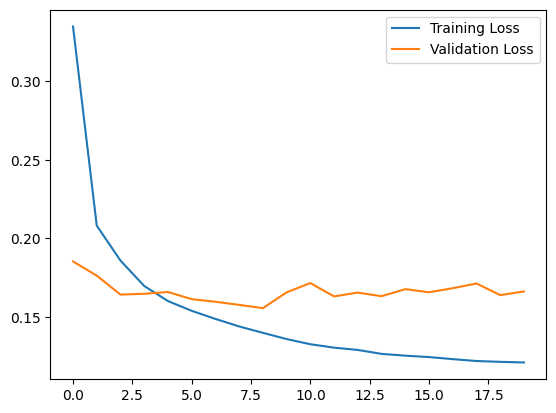

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

# Results


In [ ]:
#Creating testing data with actual and alterted data
X_Test_Clean.shape

(27766, 27)

In [ ]:
#Reconstruction Error with Noisy Data
test_x_predictions = autoencoder.predict(X_test_noisy)
mse = np.mean(np.power(X_test_noisy - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})
print(Y_test_noisy.nunique())
error_df['True_Class'] =1
print(error_df.head())

868/868 [==============================] - 2s 2ms/step
1
        Reconstruction_error  True_Class
69752               0.380267           1
101036              0.315522           1
16709               0.573241           1
5708                0.487308           1
24653               0.637131           1


In [ ]:
X_Test_Clean.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,EOL,MOL
105668,0.440004,0.440004,0.555689,0.379223,0.417518,0.324777,0.367208,0.408926,0.693092,-0.548158,...,-0.372779,0.497044,0.500399,0.352054,0.680366,0.477066,0.477066,-0.321102,1,0
20705,0.440004,0.440004,-0.563133,-2.480611,-2.330919,-2.530317,-2.380706,-2.351739,-0.855267,-0.502114,...,-0.412158,-2.264384,-1.967122,-2.467513,-1.757942,-2.563714,-2.563714,-0.321102,0,1
110299,0.440004,0.440004,0.610770,0.497420,0.531287,0.466400,0.477477,0.519710,0.691776,-0.549154,...,-0.245394,0.782932,0.799571,0.478942,0.711445,0.481105,0.481105,-0.321102,0,0
73592,0.440004,0.440004,0.574348,0.393568,0.431325,0.373189,0.381035,0.422818,0.623542,-0.546785,...,-0.234244,0.498687,0.502195,0.382552,0.652013,0.473385,0.473385,-0.321102,0,1
110828,0.440004,0.440004,0.602106,0.492424,0.526478,0.443939,0.473860,0.516088,0.553056,-0.546795,...,-0.266322,0.788272,0.806065,0.465935,0.645924,0.472588,0.472588,-0.321102,0,1


In [ ]:
#Reconstruction Error with Clean Data
test_x_predictions_clean = autoencoder.predict(X_Test_Clean)
mse = np.mean(np.power(X_Test_Clean - test_x_predictions_clean, 2), axis=1)
error_dfclean = pd.DataFrame({'Reconstruction_error': mse})
print(Y_test_noisy.nunique())
error_dfclean['True_Class'] =Y_Test_Clean
print(error_dfclean.head())

868/868 [==============================] - 1s 2ms/step
1
        Reconstruction_error  True_Class
105668              0.037146           0
20705               0.185440           0
110299              0.141561           0
73592               0.037917           0
110828              0.049123           0


In [ ]:
print(X_Test_Clean.shape)
print(X_test_noisy.shape)
frames=[X_Test_Clean, X_test_noisy]
X_test_Combo= pd.concat(frames)
print(X_test_Combo.shape)
print(Y_Test_Clean.shape)
print(Y_test_noisy.shape)
frames_2=[Y_Test_Clean,Y_test_noisy]
Y_test_Combo= pd.concat(frames_2)
print(Y_test_Combo.shape)

(27766, 27)
(27767, 27)
(55533, 27)
(27766,)
(27767,)
(55533,)


In [ ]:
X_test_Combo

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,EOL,MOL
105668,0.440004,0.440004,0.555689,0.379223,0.417518,0.324777,0.367208,0.408926,0.693092,-0.548158,...,-0.372779,0.497044,0.500399,0.352054,0.680366,0.477066,0.477066,-0.321102,1,0
20705,0.440004,0.440004,-0.563133,-2.480611,-2.330919,-2.530317,-2.380706,-2.351739,-0.855267,-0.502114,...,-0.412158,-2.264384,-1.967122,-2.467513,-1.757942,-2.563714,-2.563714,-0.321102,0,1
110299,0.440004,0.440004,0.610770,0.497420,0.531287,0.466400,0.477477,0.519710,0.691776,-0.549154,...,-0.245394,0.782932,0.799571,0.478942,0.711445,0.481105,0.481105,-0.321102,0,0
73592,0.440004,0.440004,0.574348,0.393568,0.431325,0.373189,0.381035,0.422818,0.623542,-0.546785,...,-0.234244,0.498687,0.502195,0.382552,0.652013,0.473385,0.473385,-0.321102,0,1
110828,0.440004,0.440004,0.602106,0.492424,0.526478,0.443939,0.473860,0.516088,0.553056,-0.546795,...,-0.266322,0.788272,0.806065,0.465935,0.645924,0.472588,0.472588,-0.321102,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21365,0.372431,0.372431,-0.663348,-2.635188,-2.481020,-2.693984,-2.519190,-2.490407,-0.988995,-0.574264,...,0.686493,-2.486873,-2.424037,-2.618751,-1.825515,-2.745141,-2.745141,-0.388675,1,0
105095,0.372431,0.372431,0.488432,0.313159,0.351398,0.257970,0.301028,0.342752,0.605837,-0.616179,...,0.687494,0.445681,0.450339,0.285596,0.606295,0.408651,0.408651,-0.388675,1,0
88609,0.372431,0.372431,0.551394,0.291514,0.330563,0.422893,0.280236,0.321683,0.539693,-0.616134,...,0.692482,0.422868,0.425607,0.353671,0.675542,0.417626,0.417626,-0.388675,1,0
59942,-2.340280,-2.340280,-2.156492,0.320086,0.349990,0.248533,0.307722,0.341398,-2.017937,2.041073,...,0.725778,0.429629,0.432999,0.284516,0.613202,0.409548,0.409548,-0.388675,1,0


In [ ]:
#Calculate Reconstruction Error with Both Clean and Altered Data.
test_x_predictions = autoencoder.predict(X_test_Combo)
mse = np.mean(np.power(X_test_Combo - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})
print(Y_test_noisy.nunique())
error_df['True_Class'] =Y_test_Combo
print(error_df.head())

1736/1736 [==============================] - 3s 2ms/step
1
        Reconstruction_error  True_Class
105668              0.037146           0
20705               0.185440           0
110299              0.141561           0
73592               0.037917           0
110828              0.049123           0


In [ ]:
threshold = 0.3 # currently eyeballing from normal/altered graphs below
print("Threshold: ", threshold)

Threshold:  0.3


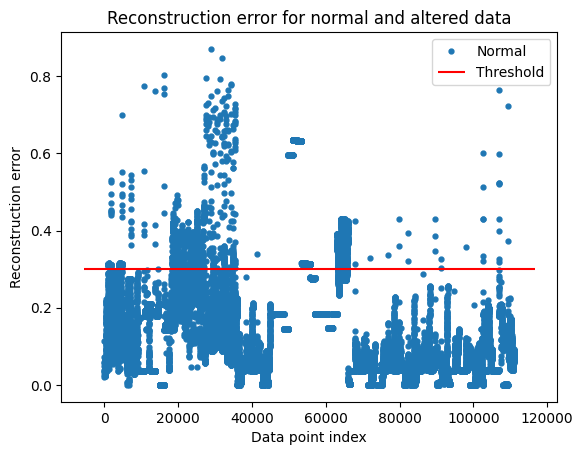

In [ ]:
#Visualize Reconstruction Error
threshold_fixed = threshold
groups = error_dfclean.groupby('True_Class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Altered Data" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and altered data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

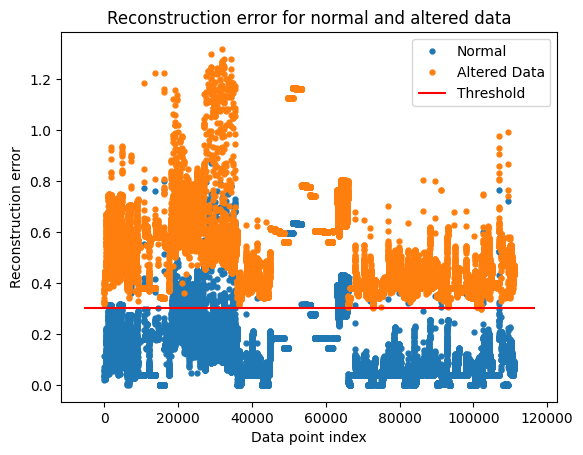

In [ ]:
#Visualize Reconstruction Error
threshold_fixed = threshold
groups = error_df.groupby('True_Class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Altered Data" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and altered data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
threshold_fixed =threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
y_true=Y_test_Combo
print(y_true.head())

105668    0
20705     0
110299    0
73592     0
110828    0
Name: 34, dtype: int64


The accuracy shown below tells us how successful out autoencoder was in detecting anomalies, which in this case is our trojaned data. The recall tells us how many trojaned data were classified as altered data.

In [ ]:
# print Accuracy, precision and recall
acc = accuracy_score(y_true, pred_y) * 100
ps = precision_score(y_true, pred_y) * 100
rs = recall_score(y_true, pred_y) * 100
f1 = f1_score(y_true, pred_y) * 100
print("Threshold: ", threshold)
print('Accuracy of this model is:', acc)
print('Precision of this model is:', ps)
print('Recall of this model is:', rs)
print('F1 of this model is:', f1)

Threshold:  0.3
Accuracy of this model is: 98.50539318963499
Precision of this model is: 97.09759765010317
Recall of this model is: 100.0
F1 of this model is: 98.5274288552977


Confusion matrix, without normalization
[[26936   830]
 [    0 27767]]


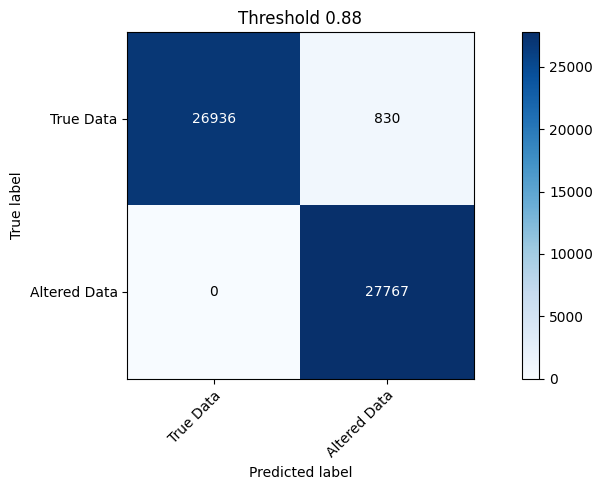

In [ ]:
#Visualization of Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, pred_y)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,5))
    fig.set(dpi=100)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label',

          )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names=['True Data', 'Altered Data']
plot_confusion_matrix(y_true, pred_y, classes=class_names,
                      title='Threshold 0.88')

plt.savefig('test.png', bbox_inches='tight')

The confusion matrix allows us to see how our data was classified. We want a low number of altered data being classified as true data. In our case, we do not want any trojaned data (altered) being classified as benign (true).